# Домашнее задание №2

Задание присылать на почту **aleksartmonov@gmail.com** в форматах *.ipynb* и отрендеренный результат в *.html*

В теме письма указать **AU2018 HW2 <Фамилия Имя>**

soft deadline: 04.03.2018T23:59:00+0300

hard deadline: 11.03.2018T23:59:00+0300

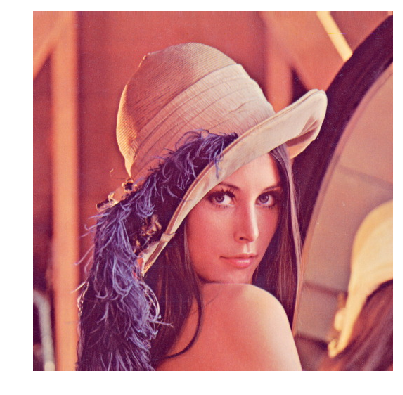

In [1]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from ipywidgets import interact
%matplotlib inline

def show(img, figsize=(5, 5), **kwargs):
    plt.figure(figsize=figsize)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(img, **kwargs)

lena = cv2.cvtColor(cv2.imread("lena.jpg"), cv2.COLOR_BGR2RGB)
show(lena)

**1. (6 баллов)** С помощью [виджетов](http://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html) создайте 2 слайдера с настройками параметров гамма-коррекции. Отобразите **lena**, ее гамма-преобразование и график в диапозоне от [0;1], так, чтобы параметры слайдера соответствовали параметрам гамма-коррекции. 

In [2]:
def gamma_correction(img, const, gamma):
    return np.uint8(255 * const * (img / 255) ** gamma)

def show_correction(img, const, gamma):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
    ax0.set_axis_off()
    ax0.imshow(gamma_correction(img, const, gamma))
    
    x = np.arange(0, 1, 0.001)
    ax1.plot(x, const * x ** gamma)
    
f = lambda const, gamma: show_correction(lena, const, gamma)
interact(f, const=(0, 3, 0.1), gamma=(0, 3, 0.1));

interactive(children=(FloatSlider(value=1.0, description='const', max=3.0), FloatSlider(value=1.0, description='gamma', max=3.0), Output()), _dom_classes=('widget-interact',))

**2. (3 балла)** Загрузите изображение $lena.jpg$. Переведите изображение в градации серого. Примените к серому изображению операцию линейного растяжения диапазона яркостей ($normalize$) и эквализации гистограммы ($equalizeHist$). Постройте разность полученных результатов. Состыкуйте в одно изображение в градациях серого результат линейного растяжения, эквализации и их разности.

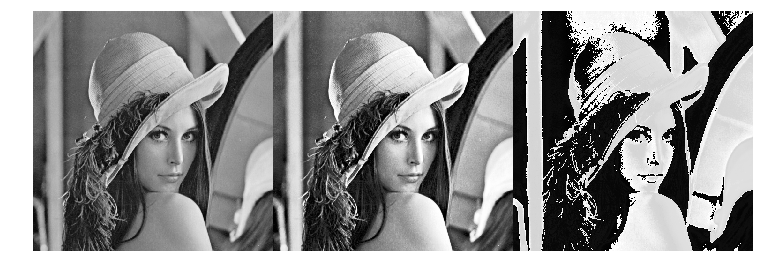

In [3]:
lena_gray = cv2.cvtColor(lena, cv2.COLOR_RGB2GRAY)

lena_gray_linear = np.zeros(lena_gray.shape, dtype=np.float32)
cv2.normalize(lena_gray, alpha=0, beta=255, dst=lena_gray_linear, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
lena_gray_linear = lena_gray_linear.astype(np.uint8)

lena_gray_hist = cv2.equalizeHist(lena_gray)

img = np.hstack((lena_gray_linear, lena_gray_hist, abs(lena_gray_linear - lena_gray_hist)))

show(img, figsize=(10, 5), cmap='gray')

**3. (3 балла) ** Реализуйте функцию добавления шума «соль и перец» для одноканального изображения. Входные параметры: $src$ – исходная одноканальная матрица $Mat$, $p$ – вероятность замещения исходных значений на $0$, $q$ – вероятность замещения исходных значений на $255$. Загрузите изображение $lena.jpg$, выделите каналы изображения в отдельные матрицы ($split$), добавьте шум «соль и перец» в каждый канал при помощи реализованной Вами функции с параметрами

1. $p=q=0.05$
2. $p=q=0.1$
3. $p=q=0.15$

In [4]:
def salt_pepper(src, p, q):
    prob = np.random.uniform(0, 1, size=src.shape)
    src[prob < p] = 0
    src[prob > 1 - q] = 255
    return src

In [5]:
def salt_pepper_img(img, p, q):
    channels = np.split(img, 3, axis=2)
    img = np.concatenate([salt_pepper(channel, p, p) for channel in channels], axis=2)
    return img

In [6]:
prob = [0.05, 0.10, 0.15]
img = np.concatenate([salt_pepper_img(lena.copy(), p, p) for p in prob], axis=1)

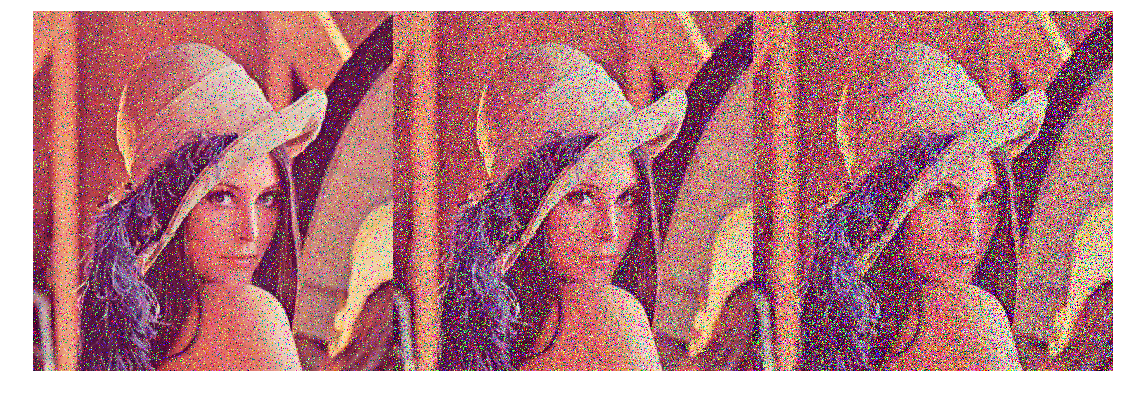

In [7]:
show(img, figsize=(15, 10))

**5. (6 баллов)** Загрузите изображение $lena.jpg$ (512х512). Переведите изображение в градации серого. Произведите фильтрацию данного изображения в частотной области идеальным фильтром низких частот (фильтр, обрезающий все высокочастотные составляющие Фурье-образа, находящиеся на большем расстоянии от начала координат, чем некоторое заданное расстояние $D$), идеальным фильтром высоких частот (фильтр, обрезающий все низкокочастотные составляющие Фурье-образа, находящиеся на меньшем расстоянии от начала координат, чем некоторое заданное расстояние $D$) со  значениями радиуса фильтров, которые будут задаваться с помощью слайдера, как в задании **1**.

Для каждого фильтра постройте состыкованное изображение из следующих: исходное изображение в градациях серого, изображение Фурье-спектра (после логарифмической коррекции для лучшей визуализации), изображение Фурье-спектра после фильтрации, изображение в пространственной области после фильтрации. Итого для каждого $D$ должно рисоваться 8 картинок. 

In [8]:
def circle_mask(shape, radius):
    mask = np.zeros((shape[0], shape[1]), np.uint8)
    cx, cy = shape[0] // 2, shape[1] // 2
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            mask[i, j] = 1 if (i - cx) ** 2 + (j - cy) ** 2 <= radius ** 2 else 0
    
    return mask

def img2dft(img):
    return np.fft.fftshift(cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT))

def dft2img(dft):
    return cv2.idft(np.fft.ifftshift(dft), flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)

def get_magnitude(dft):
    return 20 * np.log(cv2.magnitude(dft[:, :, 0], dft[:, :, 1]))

def freq_filter(img, mask):
    mask = np.repeat(mask.reshape((512, 512, 1)), 2, axis=2)
    dft = img2dft(img)
    magnitude = get_magnitude(dft)
    img_back = dft2img(dft * mask)
    
    img = np.concatenate((img, magnitude, magnitude * mask[:, :, 0], img_back), axis=1)
    show(img, figsize=(15, 10), cmap='gray')

In [9]:
f = lambda low_freq_dist: freq_filter(lena_gray, circle_mask(lena_gray.shape, low_freq_dist))
interact(f, low_freq_dist=(0, 256, 10));

interactive(children=(IntSlider(value=120, description='low_freq_dist', max=256, step=10), Output()), _dom_classes=('widget-interact',))

In [10]:
f = lambda high_freq_dist: freq_filter(lena_gray, 1 - circle_mask(lena_gray.shape, high_freq_dist))
interact(f, high_freq_dist=(0, 256, 10));

interactive(children=(IntSlider(value=120, description='high_freq_dist', max=256, step=10), Output()), _dom_classes=('widget-interact',))

**6. (5 баллов) **Удалите диагональные полоски с изображения $lena\_diagonal.jpg$. Вычислите среднеквадратичную ошибку (mean squared error, $MSE$, \url{http://en.wikipedia.org/wiki/Mean_squared_error}) для полученного результата и изображения $lena\_gray\_512.tif$. Задача будет засчитана при $MSE < 1500$. Тот, у кого по результатам проверки будет наименьшее значение MSE среди всех студентов для этой задачи, получит призовую шоколадку (раньше мы раздавали призовые баллы, но теперь у нас концепция фиксированного максимального количества баллов)

In [11]:
def mse(img1, img2):
    return np.mean((img1.astype(int) - img2.astype(int)) ** 2)

MSE: 3484.66450881958


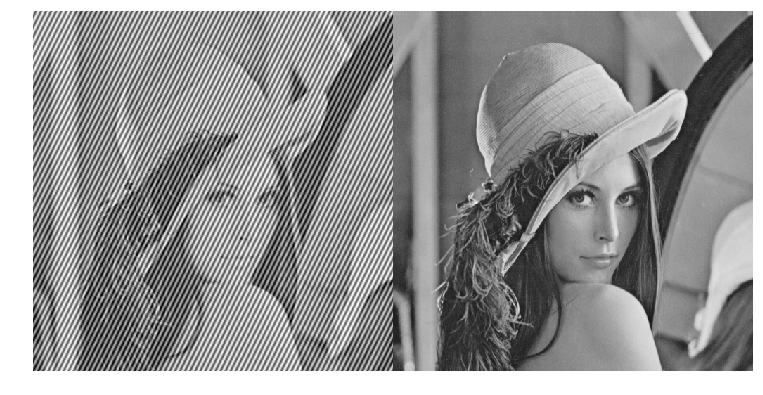

In [12]:
img_orig = cv2.cvtColor(cv2.imread('lena_gray_512.tif'), cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(cv2.imread('lena_diagonal.jpg'), cv2.COLOR_BGR2GRAY)
show(np.concatenate((img, img_orig), axis=1), figsize=(10, 5), cmap='gray')
print(f'MSE: {mse(img, img_orig)}') 

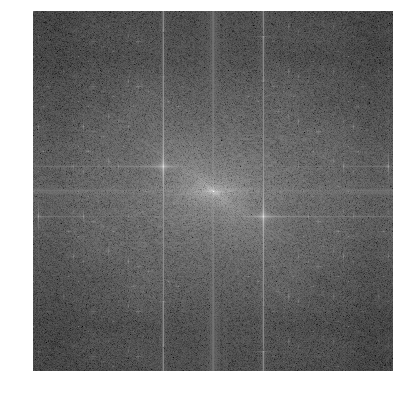

In [13]:
dft = img2dft(img)
magnitude = get_magnitude(dft)
show(magnitude, cmap='gray')

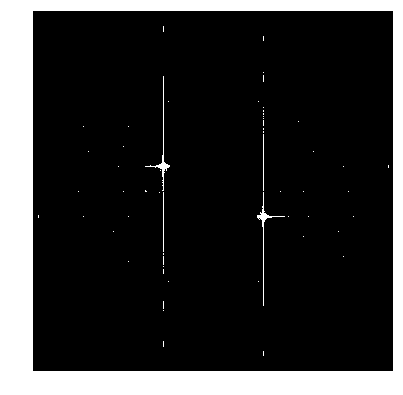

In [14]:
mask = 1 - circle_mask(magnitude.shape, 71)
mask *= (magnitude > 201)
show(mask, cmap='gray')

MSE: 873.2511100769043


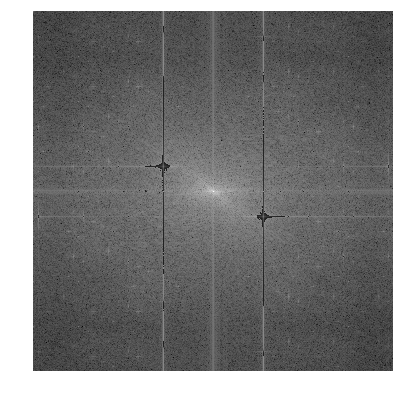

In [15]:
mask_new = np.repeat(mask.reshape(512, 512, 1), 2, axis=2)
dft_new = dft * (1 - mask_new) + 1e-3 * dft * mask_new

magnitude_new = get_magnitude(dft_new)
img_back = dft2img(dft_new)

show(magnitude_new, cmap='gray')
print(f'MSE: {mse(img_back, img_orig)}')

MSE: 364.1577835083008


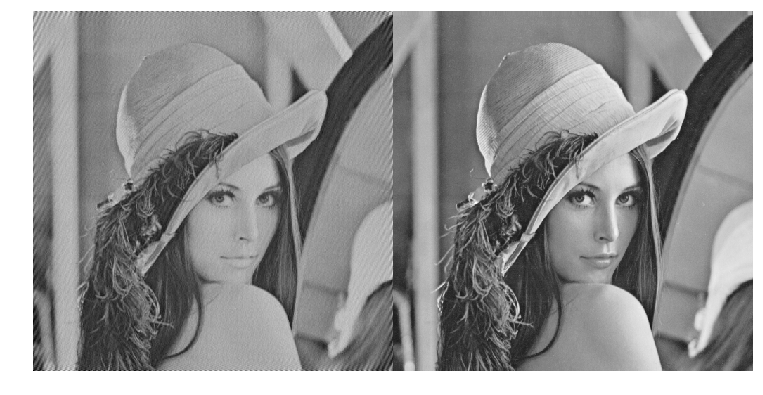

In [16]:
cv2.normalize(img_back, alpha=0, beta=224, dst=img_back, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F);
show(np.concatenate((img_back, img_orig), axis=1), figsize=(10, 5), cmap='gray')
print(f'MSE: {mse(img_back, img_orig)}')

**7. (5 баллов)** Подавите шум на изображении $lena\_color\_512\_noise.tif$. Вычислите среднеквадратичную ошибку ($MSE$) для полученного результата и изображения $lena\_color\_512.tif$. Задача будет засчитана при $MSE < 150$. Тот, у кого по результатам проверки будет наименьшее значение $MSE$ среди всех студентов для этой задачи, получит призовую шоколадку.

MSE: 2184.1810162862143


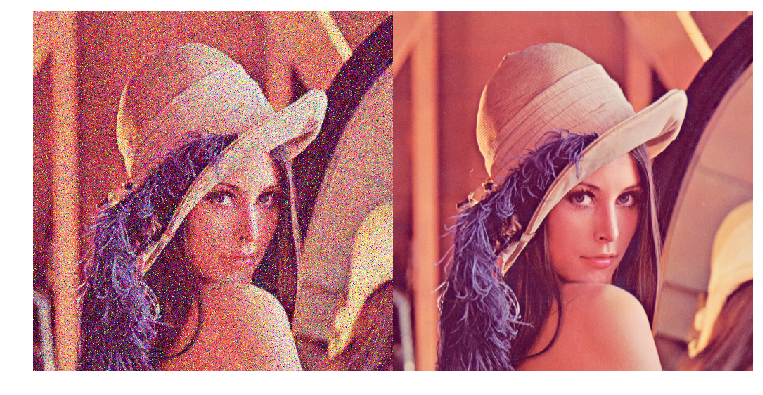

In [17]:
img_orig = cv2.cvtColor(cv2.imread('lena_color_512.tif'), cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(cv2.imread('lena_color_512-noise.tif'), cv2.COLOR_BGR2RGB)
show(np.concatenate((img, img_orig), axis=1), figsize=(10, 5))
print(f'MSE: {mse(img, img_orig)}')

In [18]:
def smoothing(img, sz):
    kernel = np.ones((sz, sz)) / (sz ** 2)
    return cv2.filter2D(img, -1, kernel)

MSE: 201.64909744262695


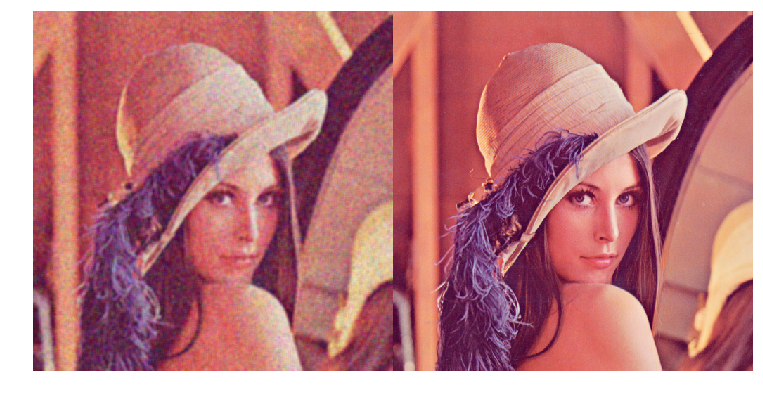

In [19]:
img_sm = smoothing(img, 5)
show(np.concatenate((img_sm, img_orig), axis=1), figsize=(10, 5))
print(f'MSE: {mse(img_sm, img_orig)}')

In [20]:
def median_blur(img, sz=2):
    out = np.zeros(img.shape)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            min_i, max_i = max(i - sz, 0), min(i + sz + 1, img.shape[0])
            min_j, max_j = max(j - sz, 0), min(j + sz + 1, img.shape[1])

            for k in range(img.shape[2]):
                out[i, j, k] = np.median(img[min_i:max_i, min_j:max_j, k])
                
    return out

MSE: 157.69206619262695


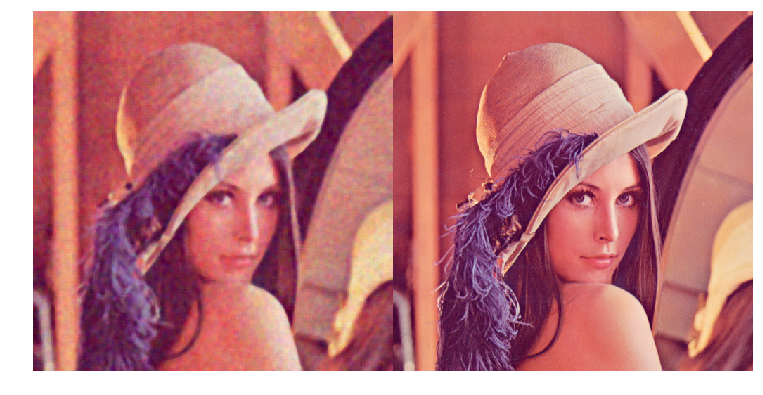

In [21]:
img_bl = median_blur(img, sz=3)
show(np.concatenate((img_bl.astype(np.uint8), img_orig), axis=1), figsize=(10, 5))
print(f'MSE: {mse(img_bl, img_orig)}')

MSE: 148.31829579671225


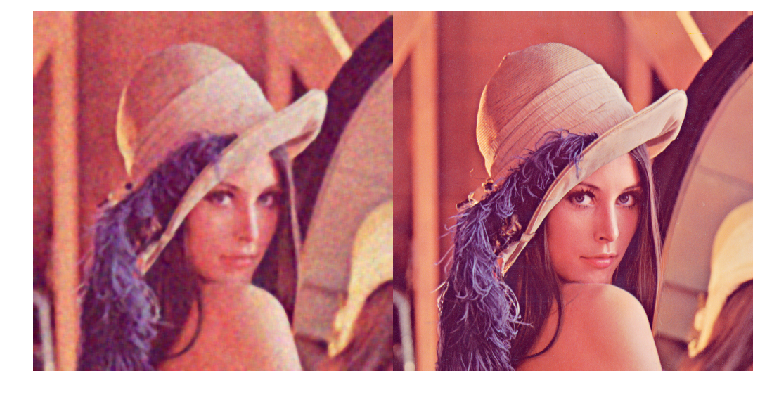

In [23]:
img_avg = 0.75 * img_bl.astype(np.float) + 0.25 * img_sm
img_avg = 255 * (img_avg - img_avg.min()) / (img_avg.max() - img_avg.min())
show(np.concatenate((img_avg.astype(np.uint8), img_orig), axis=1), figsize=(10, 5))
print(f'MSE: {mse(img_avg, img_orig)}')

**8. (5 баллов)** Реализуйте функцию пространственной фильтрации изображения однородным усредняющим фильтром размера $n \times n$ (все коэффициенты маски равны $\frac{1}{n^2}$). При вычислении среднего используйте тот факт, что при переходе от точки к точке обновляется только часть элементов изображения под маской. Примените реализованный фильтр к предварительно переведенному в градации серого изображению $lena.jpg$ при $n = 3$ и $n = 5$. Постройте и сохраните изображение, представляющее собой разность полученных результатов фильтрации.

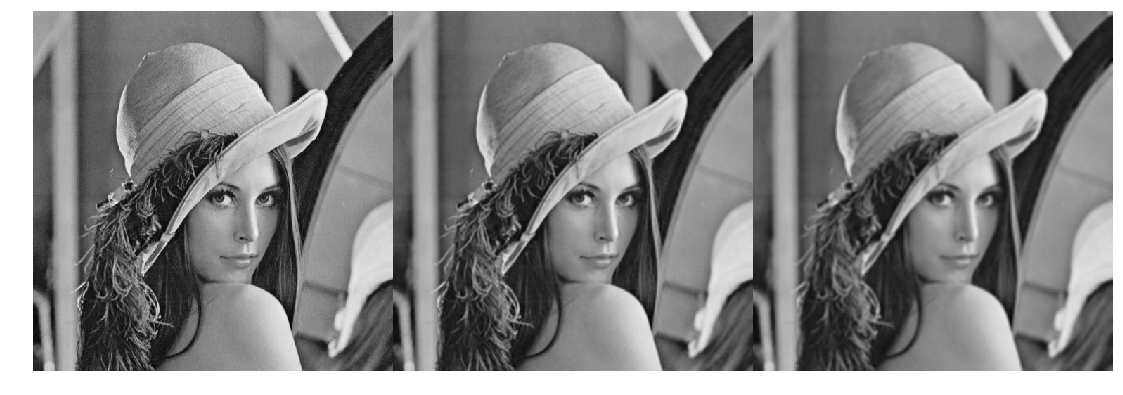

In [24]:
lena_smooth_3 = smoothing(lena_gray, 3)
lena_smooth_5 = smoothing(lena_gray, 5)
show(np.concatenate((lena_gray, lena_smooth_3, lena_smooth_5), axis=1), figsize=(15, 5), cmap='gray')

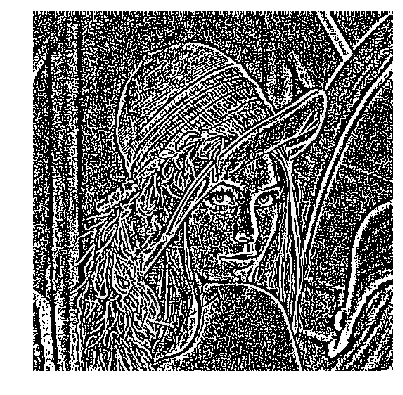

In [25]:
show(np.abs(lena_smooth_5 - lena_smooth_3), cmap='gray')
plt.savefig('lena_contour.png')